In [3]:
# load packages
import pandas as pd
import re
import gffutils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#  Functions

In [4]:
# function to count the number of values seperated by comma in a dataframe field
# if NaN is present, it will be counted as 0

def count_comma_separated_values(df, column_name):
    def count_values(cell):
        if pd.isna(cell):
            return 0
        return len(str(cell).split(','))

    return df[column_name].apply(count_values)



def check_length_values(row, percent):
    min_value = row.min()
    max_value = row.max()

    # Calculate the 1% range
    cutoff_percent = min_value * percent * 0.01

    # Check if all values are within 1% of each other
    return max_value >= min_value + cutoff_percent


def add_length_category(df):
    # Select only the relevant columns
    df_subset = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']]


    df_subset = df_subset.astype(int)

    # print max and min values of each row
    df['length_category'] = 'unclassified'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 0), axis=1), 'length_category'] = 'less_1%_difference'
    df.loc[df_subset.apply(lambda x: check_length_values(x, 1), axis=1), 'length_category'] = 'more_1%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 5), axis=1), 'length_category'] = 'more_5%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 10), axis=1), 'length_category'] = 'more_10%_difference'


    df.loc[df_subset.apply(lambda x: check_length_values(x, 20), axis=1), 'length_category'] = 'more_20%_difference'
    return df

def add_length_differences_percent(df):
    df_subset = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']]
    df_subset = df_subset.astype(int)

    # Calculate the differences between the columns
    # max difference
    df['max_difference'] = df_subset.max(axis=1) - df_subset.min(axis=1)

    # calculate the percentage difference
    df['percent_difference'] = df['max_difference'] / df_subset.min(axis=1) * 100

    return df

def add_longest_transcript(df):

    df['haplotype_with_longest_annotation'] = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].idxmax(axis=1)
    mask = (df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].nunique(axis=1) == 1)
    df.loc[mask, 'haplotype_with_longest_annotation'] = 'equal_lengths'
    df['haplotype_with_longest_annotation'] = df['haplotype_with_longest_annotation'].str.replace('ref_length_', '')
    #df.loc[df['length_category'] == 'less_1%_difference', 'haplotype_with_longest_annotation'] = 'lengths_within_5%'
    return df

def make_barplot(df):
    plt.figure(figsize=(5, 5))
    # Sort the DataFrame by the 'length_category' column
    custom_order = ['less_1%_difference','more_1%_difference', 'more_5%_difference', 'more_10%_difference', 'more_20%_difference']  # replace with your actual categories
    df['length_category'] = pd.Categorical(df['length_category'], categories=custom_order, ordered=True)
    # chagne the haplotype_with_longest_annotation to a categorical variable
    df['haplotype_with_longest_annotation'] = pd.Categorical(df['haplotype_with_longest_annotation'], categories=['2G', '4G', '1G', '3G', 'equal_lengths'], ordered=True)
    #sns.countplot(x='length_category', hue='haplotype_with_longest_annotation', data=df)
    sns.histplot(data=df, x='length_category', hue='haplotype_with_longest_annotation', multiple='stack')
    plt.xlabel('Length Category')
    plt.ylabel('Count')
    # turn the x-axis labels
    plt.xticks(rotation=90)
    plt.ylim(0, 12000)
    plt.title('Counts of Length Categories')
    plt.tight_layout()
    # show the plot
    plt.show()

def make_histplot(df):
    plt.figure(figsize=(5, 5))
    #sns.countplot(x='length_category', hue='haplotype_with_longest_annotation', data=df)
    sns.histplot(data=df, x='percent_difference', hue='haplotype_with_longest_annotation', multiple='stack')
    plt.xlabel('Length Category')
    plt.ylabel('Count')
    # turn the x-axis labels
    plt.xticks(rotation=90)
    plt.xlim(0, 100)
    plt.title('Counts of Length Categories')
    plt.tight_layout()
    # show the plot
    plt.show()

def get_transcript_lengths(gff_file):
    # Create a database from the GFF file
    db = gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True,
                            merge_strategy='merge', sort_attribute_values=True)

    # Initialize an empty dictionary to store transcript lengths
    transcript_lengths = {}

    # Iterate over all features of type 'exon' in the GFF file
    for exon in db.features_of_type('gene'):

        parent_id = exon.attributes['ID'][0]
        length = exon.end - exon.start + 1
        if parent_id not in transcript_lengths:
            transcript_lengths[parent_id] = 0

        transcript_lengths[parent_id] += length
    print(transcript_lengths)

    # Create a DataFrame from the dictionary
    df = pd.DataFrame.from_dict(transcript_lengths, orient='index', columns=['ref_length'])
    return df

def get_transcript_lengths(gff_file, attribute):
    # Create a database from the GFF file
    db = gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True,
                            merge_strategy='merge', sort_attribute_values=True)

    # Initialize a dictionary to store transcript lengths and start coordinates
    transcript_info = {}

    # Iterate over all features of type 'exon' in the GFF file
    for exon in db.features_of_type(attribute):
        parent_id = exon.attributes['Parent'][0]
        length = exon.end - exon.start + 1
        
        if parent_id not in transcript_info:
            # Get the parent transcript feature
            parent = db[parent_id]
            transcript_info[parent_id] = {'ref_length': 0, 'parent_start': parent.start}
        
        transcript_info[parent_id]['ref_length'] += length
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(transcript_info, orient='index')
    return df


def get_multimapping_tags(df):
    # extract the tnames that contain "&"
    df = df[df['haplotype_id'].str.contains('&')]
    print(df)
    # rename num_reads to multimapping_reads
    df = df.rename(columns={'num_reads': 'multimapping_reads'})
    return df

def sum_sample_counts(df):
    # sum the counts for each sample and skip the first column
    df['num_reads'] = df.iloc[:, 1:].sum(axis=1)

    return df

pd.options.mode.chained_assignment = None

sns.set_theme(style='ticks', rc={
    'figure.figsize': (4, 4),  # figure size in inches
    'axes.labelsize': 10,           # font size of the x and y labels
    'xtick.labelsize': 10,          # font size of the tick labels
    'ytick.labelsize': 10,          # font size of the tick labels
    'legend.fontsize': 7,          # font size of the legend
    "axes.spines.right": False, 
    "axes.spines.top": False})



# Load input file
def load_input(input_file):
    return pd.read_csv(input_file, sep='\t')

def add_mulitmapping_ratio( df, multi):
    # join the two dataframes
    df = df.join(multi.set_index('Synt'), on='Synt')
    # calculate the ratio of multimapping reads vs total reads
    df['multimapping_ratio'] = df['multimapping_reads'] / (df['hap1'] + df['hap2'] + df['hap3'] +  df['hap4']+ df['multimapping_reads'])
    # add a tag if the multimapping ratio is above 0.25
    df['multimapping_tag'] = np.where(df['multimapping_ratio'] > 0.25, 'multimapping', 'unique')
    return df

def get_allele_ratio(df):
    # replace NaN with 0
    df = df.fillna(0)
    df['allele_ratio_hap1'] = df['1'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap2'] = df['2'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap3'] = df['3'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap4'] = df['4'] / (df['1'] + df['2'] + df['3'] + df['4'])

    return df

def plot_hist(df, my_hue='multimapping_tag'):
    # Ensure NaN allele ratios are set to 0
    #df = df.fillna(0)
    
    # Identify haplotype columns dynamically
    hap_cols = [col for col in df.columns if col.startswith('allele_ratio_hap')]
    
    # Set up the plotting grid for side-by-side histograms
    fig, axes = plt.subplots(1, len(hap_cols), figsize=(4 * len(hap_cols), 4), sharey=True)

    # If there's only one haplotype column, axes won't be an array
    if len(hap_cols) == 1:
        axes = [axes]
    
    # Loop over haplotype columns and plot
    for ax, hap_col in zip(axes, hap_cols):
        sns.histplot(
            data=df,
            x=hap_col,
            bins=100,
            hue=my_hue,
            multiple='stack',
            ax=ax
        )
        ax.set_title(f'Histogram: {hap_col}')
        ax.set_xlim(0, 1)
        #ax.set_ylim(0, 300)
        ax.set_xlabel('Allele Ratio')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# test drip subset function

In [27]:
def drop_subset_rows_optimized(df: pd.DataFrame, na_values: Optional[List] = None, print_pairs: bool = True) -> pd.DataFrame:
    """
    Optimized function to drop rows that are subsets of other rows in the dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe
    na_values : list, optional
        List of values to treat as NA besides pandas defaults
    print_pairs : bool, default=True
        Whether to print the subset-superset pairs
        
    Returns:
    --------
    pd.DataFrame
        A dataframe with subset rows removed
    """
    if na_values is None:
        na_values = ['NA', 'N/A', '', None]
    
    # Track rows to drop and their corresponding superset rows
    rows_to_drop = set()
    subset_superset_pairs = {}
    
    # Pattern to match gene IDs and remove special characters at the end
    gene_pattern = r'(Soltu\.Des\.v1_[A-Za-z0-9\.]+\d+)[\*\+]?'
    
    # Pre-process all cells and extract gene sets for each cell
    # This avoids repeatedly parsing the same strings during comparisons
    row_data = []
    
    for idx, row in df.iterrows():
        row_genes = {}
        for col in df.columns:
            value = row[col]
            if pd.isna(value) or value in na_values:
                row_genes[col] = set()
            else:
                # Extract genes, normalize by removing special characters
                if isinstance(value, str):
                    genes = set(re.findall(gene_pattern, value))
                    row_genes[col] = genes
                else:
                    # Handle non-string values
                    row_genes[col] = {str(value)}
        
        row_data.append((idx, row_genes))
    
    # Create an index of which rows contain each gene
    # This allows us to quickly find potential supersets
    gene_to_rows = defaultdict(set)
    for idx, row_genes in row_data:
        for col, genes in row_genes.items():
            for gene in genes:
                gene_to_rows[f"{col}:{gene}"].add(idx)
    
    # Optimize comparison strategy - compare each row with potential supersets only
    for i, (idx_i, row_genes_i) in enumerate(row_data):
        if idx_i in rows_to_drop:
            continue
        
        # Collect all potential superset rows by finding rows that contain
        # at least one gene from each column where row_i has genes
        potential_supersets = set()
        is_empty_row = True
        
        for col, genes in row_genes_i.items():
            if not genes:
                continue
                
            is_empty_row = False
            # Find rows that contain at least one gene from this column
            for gene in genes:
                potential_supersets.update(gene_to_rows[f"{col}:{gene}"])
        
        # If the row is entirely empty (all NA), it's a subset of every row
        if is_empty_row and len(row_data) > 1:
            rows_to_drop.add(idx_i)
            # Just choose the first non-self row as the superset for reporting
            for j, (idx_j, _) in enumerate(row_data):
                if idx_i != idx_j:
                    subset_superset_pairs[idx_i] = idx_j
                    break
            continue
        
        # Remove self from potential supersets
        potential_supersets.discard(idx_i)
        
        # Check if row_i is a subset of any potential superset
        for idx_j in potential_supersets:
            if idx_j in rows_to_drop:
                continue
                
            # Find the row_genes for idx_j
            row_genes_j = next(rg for idx, rg in row_data if idx == idx_j)
            
            # Check if row_i is a subset of row_j
            is_subset = True
            
            for col in df.columns:
                genes_i = row_genes_i[col]
                genes_j = row_genes_j[col]
                
                # If row_i has genes that are not in row_j for this column, 
                # it's not a subset
                if genes_i and not genes_i.issubset(genes_j):
                    is_subset = False
                    break
            
            if is_subset:
                rows_to_drop.add(idx_i)
                subset_superset_pairs[idx_i] = idx_j
                break
    
    # Print the subset-superset pairs if requested
    if print_pairs and subset_superset_pairs:
        print(f"Found {len(subset_superset_pairs)} subset rows to remove:\n")
        
        # for subset_idx, superset_idx in subset_superset_pairs.items():
        #     print("SUBSET ROW (index {}):\n{}".format(subset_idx, df.loc[subset_idx].to_string()))
        #     print("\nSUPERSET ROW (index {}):\n{}".format(superset_idx, df.loc[superset_idx].to_string()))
        #     print("\n" + "-"*80 + "\n")
    
    # Drop the identified subset rows
    return df.drop(rows_to_drop)

import pandas as pd
import re
import numpy as np
from collections import defaultdict, deque
from typing import Dict, Set, List, Optional, Tuple, Union


def identify_overlapping_rows(df: pd.DataFrame, na_values: Optional[List] = None) -> Dict[int, Set[int]]:
    """
    Identify groups of rows that have overlapping gene IDs.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe
    na_values : list, optional
        List of values to treat as NA besides pandas defaults
        
    Returns:
    --------
    Dict[int, Set[int]]
        Dictionary mapping row indices to sets of connected row indices (including itself)
    """
    if na_values is None:
        na_values = ['NA', 'N/A', '', None]
    
    # Pattern to match gene IDs and remove special characters at the end
    gene_pattern = r'(Soltu\.Des\.v1_[A-Za-z0-9\.]+\d+)[\*\+]?'
    
    # Map gene IDs to the rows they appear in
    gene_to_rows = defaultdict(set)
    
    # Build the gene-to-rows mapping
    for row_idx, row in df.iterrows():
        for col in df.columns:
            value = row[col]
            
            # Skip NA values
            if pd.isna(value) or value in na_values:
                continue
            
            # Handle multiple comma-separated gene IDs in a cell
            if isinstance(value, str):
                # Find all gene IDs in this cell
                matches = re.findall(gene_pattern, value)
                for gene_id in matches:
                    gene_to_rows[gene_id].add(row_idx)
    
    # Create a graph of connected rows
    row_connections = defaultdict(set)
    
    # Connect rows that share at least one gene
    for gene, rows in gene_to_rows.items():
        if len(rows) > 1:
            # All rows with this gene are connected to each other
            for row in rows:
                row_connections[row].update(rows)
    
    # Find connected components using BFS
    components = {}
    visited = set()
    
    for start_row in row_connections:
        if start_row in visited:
            continue
        
        # BFS to find all connected rows
        queue = deque([start_row])
        component = set()
        
        while queue:
            row = queue.popleft()
            if row in visited:
                continue
                
            visited.add(row)
            component.add(row)
            
            # Add all connected rows
            for connected_row in row_connections[row]:
                if connected_row not in visited:
                    queue.append(connected_row)
        
        # Store this connected component
        for row in component:
            components[row] = component
    
    # Add singleton rows (rows not connected to any other rows)
    for row_idx in df.index:
        if row_idx not in components:
            components[row_idx] = {row_idx}
    
    return components

def merge_overlapping_rows(df: pd.DataFrame, na_values: Optional[List] = None, 
                          print_operations: bool = True) -> pd.DataFrame:
    """
    Merge rows that have overlapping gene IDs into consolidated rows.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe
    na_values : list, optional
        List of values to treat as NA besides pandas defaults
    print_operations : bool, default=True
        Whether to print information about the merge operations
        
    Returns:
    --------
    pd.DataFrame
        A new dataframe with merged rows
    """
    if na_values is None:
        na_values = ['NA', 'N/A', '', None]
    
    # Identify groups of rows that need to be merged
    components = identify_overlapping_rows(df, na_values)
    
    # Unique components (we only need one representative per component)
    unique_components = {}
    for component in components.values():
        # Use the minimum row index as the representative
        rep = min(component)
        if rep not in unique_components:
            unique_components[rep] = component
    
    if print_operations:
        num_groups = len(unique_components)
        num_affected_rows = sum(len(comp) for comp in unique_components.values())
        num_merged = num_affected_rows - num_groups
        
        print(f"Found {num_groups} groups of overlapping rows.")
        print(f"Merging {num_merged} rows into their respective groups.\n")
    
    # Pattern to match gene IDs including special characters
    gene_pattern = r'(Soltu\.Des\.v1_[A-Za-z0-9\.]+\d+[\*\+]?)'
    
    # Create the merged dataframe
    result_data = []
    
    # Process each component
    for rep, component in unique_components.items():
        if len(component) == 1:
            # Single row, no merging needed
            result_data.append(df.loc[rep].to_dict())
            continue
        
        if print_operations:
            print(f"Merging rows: {', '.join(map(str, sorted(component)))}")
        
        # Create a new merged row
        merged_row = {}
        
        # For each column, merge all gene IDs from the component rows
        for col in df.columns:
            gene_ids = set()
            
            for row_idx in component:
                value = df.at[row_idx, col]
                
                # Skip NA values
                if pd.isna(value) or value in na_values:
                    continue
                
                # Extract gene IDs including special characters
                if isinstance(value, str):
                    matches = re.findall(gene_pattern, value)
                    gene_ids.update(matches)
            
            # Create the merged cell value
            if gene_ids:
                merged_row[col] = ', '.join(sorted(set(gene_ids)))
            else:
                merged_row[col] = 'NaN'
        
        result_data.append(merged_row)
    
    # Create the result dataframe
    result_df = pd.DataFrame(result_data, columns=df.columns)
    
    if print_operations:
        print(f"\nOriginal dataframe had {len(df)} rows.")
        print(f"New dataframe has {len(result_df)} rows.")
        print(f"Reduced by {len(df) - len(result_df)} rows.")
    
    return result_df

# Example usage:
# df = pd.read_csv("your_file.csv")  # or create from other source
# print_genes_in_multiple_rows(df)
# 
# # If you want to just get the dictionary without printing
# shared_genes_dict = find_genes_in_multiple_rows(df)



df = pd.read_csv("/scratch/nadjafn/potato-allelic-orthogroups/work/f4/92cfefbb81dcae1586c7355e355065/De_v1.functional_annotations_nodigits_genespace.tsv",  sep="\t", header=0, index_col=False,nrows = 4000)
 # or create from other source
cleaned_df = drop_subset_rows_optimized(df)
cleaned_df_merged = merge_overlapping_rows(cleaned_df)

Found 265 subset rows to remove:

Found 3622 groups of overlapping rows.
Merging 113 rows into their respective groups.

Merging rows: 91, 515
Merging rows: 252, 1012
Merging rows: 331, 1363
Merging rows: 426, 2957
Merging rows: 487, 489, 1623, 3993
Merging rows: 570, 2889
Merging rows: 577, 2070
Merging rows: 579, 1244
Merging rows: 630, 632
Merging rows: 662, 1072
Merging rows: 663, 2333
Merging rows: 745, 1157, 2362, 3369
Merging rows: 814, 2258
Merging rows: 827, 3470
Merging rows: 870, 1471
Merging rows: 873, 1443
Merging rows: 893, 1754
Merging rows: 930, 3532
Merging rows: 942, 3107
Merging rows: 975, 3746
Merging rows: 986, 1642
Merging rows: 1043, 2229
Merging rows: 1044, 2230
Merging rows: 1066, 3232
Merging rows: 1076, 2170
Merging rows: 1117, 2657
Merging rows: 1125, 2567
Merging rows: 1136, 1232, 1561, 1573, 1575, 1582, 1588
Merging rows: 1140, 2197
Merging rows: 1146, 2160
Merging rows: 1233, 3600
Merging rows: 1304, 1782
Merging rows: 1306, 1347, 1376
Merging rows: 1310,

In [ ]:
# print rows that have non unique gene ids


In [28]:
# compare the number of rows before and after
print(f'Original dataframe shape: {df.shape}')
print(f'Cleaned dataframe shape: {cleaned_df.shape}')

Original dataframe shape: (4000, 4)
Cleaned dataframe shape: (3735, 4)


In [29]:
print(cleaned_df_merged)

                                                   hap1  \
0                                                   NaN   
1     Soltu.Des.v1_C08H1G001090.1*, Soltu.Des.v1_C09...   
2                                                   NaN   
3                          Soltu.Des.v1_C07H1G005670.1*   
4     Soltu.Des.v1_C01H1G004120.1, Soltu.Des.v1_C01H...   
...                                                 ...   
3617                                                NaN   
3618                        Soltu.Des.v1_C01H1G022770.1   
3619                       Soltu.Des.v1_C09H1G034570.1*   
3620                        Soltu.Des.v1_C01H1G022780.1   
3621                        Soltu.Des.v1_C01H1G022790.1   

                                                   hap2  \
0                          Soltu.Des.v1_C09H2G036810.1*   
1     Soltu.Des.v1_C01H2G008990.1, Soltu.Des.v1_C01H...   
2     Soltu.Des.v1_C01H2G005840.1*, Soltu.Des.v1_C01...   
3                          Soltu.Des.v1_C07H2G005790.1*

In [14]:
# print 53 rd row
print(df.iloc[53])

hap1     Soltu.Des.v1_C01H1G000450.2
hap2    Soltu.Des.v1_C01H2G004810.5*
hap3                             NaN
hap4     Soltu.Des.v1_C01H4G000570.1
Name: 53, dtype: object


# Parsing Genespace pangenes


In [21]:
# pangenes_file = "/scratch/nadjafn/potato-allelic-orthogroups/results/03_GENESPACE/De_v1.functional_annotations_nodigits_genespace.tsv"
pangenes_file = "/scratch/nadjafn/potato-allelic-orthogroups/results/03_GENESPACE/ATL_v3.hc_gene_models.repr_genespace.tsv"
# gff_file = "/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/Desiree.longest_isoforms.gff"
gff_file = "/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/ATL_v3.hc_gene_models.repr.longest_isoforms.gff"
pangenes = cleaned_df
# pangenes_file = "/scratch/nadjafn/potato-allelic-orthogroups/work/fe/f989cd4f2bfaeee4e67468fdd5ad2c/ATL_v3.hc_gene_models.repr_genespace.tsv"
#pangenes = pd.read_csv(pangenes_file, sep="\t", header=0, index_col=False)
gff = pd.read_csv(gff_file, sep="\t", header=None, index_col=False, comment='#')
gff.columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
# only keep the mRNA entries
gff = gff[gff['type'] == 'mRNA']
gff['ID'] = gff['attributes'].str.extract(r'ID=(.*?);')
# delete the attributes column
gff = gff.drop(columns=['attributes'])


# drop last of the duplicated rows
pangenes = pangenes.drop_duplicates()
gff


,seqid,source,type,start,end,score,strand,phase,ID
1,chr01_0,UGA,mRNA,999,1590,.,-,.,Soltu.Atl_v3.01_0G000010.1
7,chr01_0,UGA,mRNA,3799,6779,.,-,.,Soltu.Atl_v3.01_0G000020.1
19,chr01_0,UGA,mRNA,7842,8459,.,-,.,Soltu.Atl_v3.01_0G000030.1
23,chr01_0,UGA,mRNA,8496,8753,.,-,.,Soltu.Atl_v3.01_0G000040.1
27,chr01_0,UGA,mRNA,8780,10152,.,-,.,Soltu.Atl_v3.01_0G000050.1
...,...,...,...,...,...,...,...,...,...
1709997,scf_13953,UGA,mRNA,66,835,.,+,.,Soltu.Atl_v3.S162320.1
1710003,scf_13953,UGA,mRNA,2574,4597,.,-,.,Soltu.Atl_v3.S162330.1
1710016,scf_13956,UGA,mRNA,3881,9841,.,+,.,Soltu.Atl_v3.S162360.2
1710052,scf_13957,UGA,mRNA,297,4451,.,+,.,Soltu.Atl_v3.S162370.1


In [22]:
# remove the + and * from the gene names
pangenes_gene = pangenes.map(lambda x: x.replace("+", "").replace("*", "") if isinstance(x, str) else x)
# print the number of uniuq values in the hap1 hap2 hap3 hap4 columns
print(pangenes_gene['hap1'].nunique()+ pangenes_gene['hap2'].nunique() + pangenes_gene['hap3'].nunique() + pangenes_gene['hap4'].nunique())


10228


In [23]:
for hap in ['hap1', 'hap2', 'hap3', 'hap4']:
    pangenes[f'{hap}_count'] = count_comma_separated_values(pangenes, hap).astype(str) + hap

# add a category if all the haplotypes dont't contain a * or + in the gene nam
pangenes['true_synteny'] = 'synteny'
pangenes.loc[(pangenes['hap1'].str.contains('\*') | pangenes['hap2'].str.contains('\*') | pangenes['hap3'].str.contains('\*') | pangenes['hap4'].str.contains('\*')), 'true_synteny'] = 'no_synteny'
pangenes.loc[(pangenes['hap1'].str.contains('\+') | pangenes['hap2'].str.contains('\+') | pangenes['hap3'].str.contains('\+') | pangenes['hap4'].str.contains('\+')), 'true_synteny'] = 'no_synteny'

# add a synt_id colum to the dataframe
pangenes.reset_index(inplace=False)
pangenes['Synt_id'] = pangenes.index
# merge all the haplotype counts into one column
pangenes['synteny_category'] = pangenes['hap1_count'] + '_' + pangenes['hap2_count'] + '_' + pangenes['hap3_count'] + '_' + pangenes['hap4_count'] + '_' + pangenes['true_synteny']
pangenes_gene = pangenes.map(lambda x: x.replace("+", "").replace("*", "") if isinstance(x, str) else x)
# expand the gene column

# pivot the table
pangenes_pivot = pd.melt(pangenes_gene, id_vars= ['Synt_id', 'synteny_category'], value_vars=['hap1', 'hap2', 'hap3', 'hap4'], var_name='haplotype', value_name='gene')
# drop the rows where gene is NaN
pangenes_pivot = pangenes_pivot.dropna(subset=['gene'])

# convert gene column to a list
pangenes_pivot['gene'] = pangenes_pivot['gene'].str.split(',')
pangenes_pivot= pangenes_pivot.explode('gene')
# merge gff and pangenes_pivot
gff_pangenes = pd.merge(gff, pangenes_pivot, left_on='ID', right_on='gene', how='left')
# convert to string 
gff_pangenes['synteny_category'] = gff_pangenes['synteny_category'].astype(str)
# count the number of genes in each synteny category
synt_counts = gff_pangenes['synteny_category'].value_counts()
# if a gene is not in the top ten categories, replace it by "other"
gff_pangenes['synteny_category'] = gff_pangenes['synteny_category'].apply(lambda x: x if x in synt_counts.index[:7] else 'other')
# sort the dataframe by the synteny category
gff_pangenes = gff_pangenes.sort_values('synteny_category')

sns.set_theme(style='ticks', rc={
    'figure.figsize': (6, 4),  # figure size in inches
    'axes.labelsize': 10,           # font size of the x and y labels
    'xtick.labelsize': 10,          # font size of the tick labels
    'ytick.labelsize': 10,          # font size of the tick labels
    'legend.fontsize': 10,          # font size of the legend
    "axes.spines.right": False, 
    "axes.spines.top": False})



# plot the number of genes in each synteny category per haplotype
ax = sns.histplot(data=gff_pangenes, hue='synteny_category', x='haplotype', multiple='stack', legend=True)
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()


plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
/tmp/ipykernel_3224054/1569389867.py:6: SyntaxWarning: invalid escape sequence '\*'
  pangenes.loc[(pangenes['hap1'].str.contains('\*') | pangenes['hap2'].str.contains('\*') | pangenes['hap3'].str.con

NameError: name 'count_comma_separated_values' is not defined

In [24]:

# if a gene is not in the top ten categories, replace it by "other"
pangenes['synteny_category'] = pangenes['synteny_category'].apply(lambda x: x if x in synt_counts.index[:5] else 'other')
synt_counts = gff_pangenes['synteny_category'].value_counts()
# count the occurence of each synteny category
synteny_counts = gff_pangenes['synteny_category'].value_counts()
print(synteny_counts)
# sort the dataframe by the synteny category alphabetically
synteny_counts.sort_index(inplace=True)

explode = (0.6, 0.4, 0.3,0.1,0.2,  0, 0, 0)
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
# make a pie charr to show the distribution of synteny categories
synteny_counts.plot.pie(startangle=90, explode=explode, autopct= lambda pct: func(pct, synteny_counts))
# # print the genes that have nan values in the synteny category
gff_pangenes[gff_pangenes['synteny_category'] == 'nan']

KeyError: 'synteny_category'

In [9]:


# select only the rows that have the category 1hap1_1hap2_1hap3_1hap4
pangenes = pangenes[pangenes['synteny_category'] == '1hap1_1hap2_1hap3_1hap4_synteny']
# pivot the table to have the Synt_id as the index and the hap1 hap2 hap3 hap4 as the values

# melt 
pangenes = pangenes.reset_index()
pangenes = pangenes.melt(id_vars='Synt_id', value_vars=['hap1', 'hap2', 'hap3', 'hap4'], value_name='haplotype_id')
# rename variable to haplotype
pangenes = pangenes.rename(columns={'variable': 'haplotype'})

## Check for the genes that are syntelogs the length difference between the haplotypes

In [10]:
ref_lengths = get_transcript_lengths('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/Desiree.longest_isoforms.gff', 'exon')
# ref_lengths = get_transcript_lengths_exon('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/ATL_v3.hc_gene_models.repr.longest_isoforms.gff')
ref_lengths['haplotype_id'] = ref_lengths.index

# Merge the two dataframes
df_synt_lengths = pd.merge(pangenes, ref_lengths, on='haplotype_id', how='inner')

# group the haplotypes ids by synteny id
haplotype_ids = df_synt_lengths.groupby('Synt_id')['haplotype_id'].apply(list).reset_index()

# sort by Synt_id and print duplicated ones
haplotype_ids = haplotype_ids.sort_values(by='Synt_id')

# print duplicated Synt_ids to check if there are any
df_synt_pivot = df_synt_lengths.pivot(index='Synt_id', columns=['haplotype'], values=['ref_length','parent_start'])
# flatten the columns
df_synt_pivot.columns = ['_'.join(col) for col in df_synt_pivot.columns]
df_synt_pivot = pd.merge(df_synt_pivot, haplotype_ids, on='Synt_id', how='inner')


# # drop the synteny id column
# df_synt_pivot.index = df_synt_pivot['Synt_id']
# df_synt_pivot = df_synt_pivot.drop(columns=['Synt_id'])
# # rename the columns
# df_synt_pivot
df_synt_pivot.columns = ['Synt_id','ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G','parent_start_1G', 'parent_start_2G', 'parent_start_3G', 'parent_start_4G', 'haplotype_id']
# drop rows with missing values
df_synt_pivot = df_synt_pivot.dropna()
df_length = add_length_category(df_synt_pivot)
df_length = add_length_differences_percent(df_length)
print(df_length)
df_length_cat = add_longest_transcript(df_length)
make_barplot(df_length_cat)
make_histplot(df_length_cat)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 10 elements

## CDS

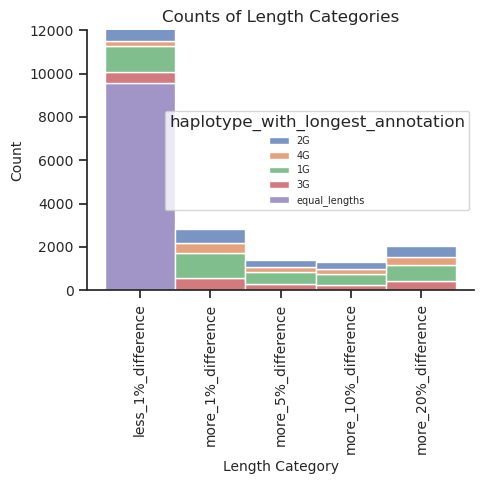

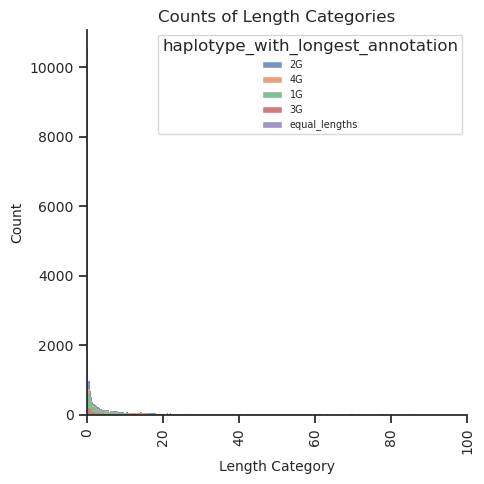

In [106]:
ref_lengths = get_transcript_lengths_CDS('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/Desiree.longest_isoforms.gff')
#ref_lengths = get_transcript_lengths_CDS('/scratch/nadjafn/potato-allelic-orthogroups/results/0_LongestIsofrom/ATL_v3.hc_gene_models.repr.longest_isoforms.gff')
ref_lengths['haplotype_id'] = ref_lengths.index

# Merge the two dataframes
df_synt_lengths = pd.merge(pangenes, ref_lengths, on='haplotype_id', how='inner')

# group the haplotypes ids by synteny id
haplotype_ids = df_synt_lengths.groupby('Synt_id')['haplotype_id'].apply(list).reset_index()

# sort by Synt_id and print duplicated ones
haplotype_ids = haplotype_ids.sort_values(by='Synt_id')

# print duplicated Synt_ids to check if there are any
df_synt_pivot = df_synt_lengths.pivot(index='Synt_id', columns=['haplotype'], values=['ref_length','parent_start'])
# flatten the columns
df_synt_pivot.columns = ['_'.join(col) for col in df_synt_pivot.columns]
df_synt_pivot = pd.merge(df_synt_pivot, haplotype_ids, on='Synt_id', how='inner')


# # drop the synteny id column
# df_synt_pivot.index = df_synt_pivot['Synt_id']
# df_synt_pivot = df_synt_pivot.drop(columns=['Synt_id'])
# # rename the columns
# df_synt_pivot
df_synt_pivot.columns = ['Synt_id','ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G','parent_start_1G', 'parent_start_2G', 'parent_start_3G', 'parent_start_4G', 'haplotype_id']
# drop rows with missing values
df_synt_pivot = df_synt_pivot.dropna()
df_length = add_length_category(df_synt_pivot)
df_length = add_length_differences_percent(df_length)
df_length_cat = add_longest_transcript(df_length)
make_barplot(df_length_cat)
make_histplot(df_length_cat)

In [107]:
# print the haplotype ids that have more than 20% difference in length
df_length_cat[df_length_cat['length_category'] == 'more_20%_difference']['haplotype_id'].values

# print the row containing this gene Soltu.Des.v1_C12H1G038990.1
# Check if 'haplotype_id' column exists and filter out NaN values
#df_length_cat[df_length_cat['haplotype_id'][0].index('Soltu.Des.v1_C12H1G038990.1')]
#df_length_cat['haplotype_id']
# df_length_cat[df_length_cat['haplotype_id'].apply(lambda x: 'Soltu.Des.v1_C06H1G031590.1' in x)]


array([list(['Soltu.Des.v1_C01H1G000190.1', 'Soltu.Des.v1_C01H2G005100.1', 'Soltu.Des.v1_C01H3G000190.1', 'Soltu.Des.v1_C01H4G000230.1']),
       list(['Soltu.Des.v1_C01H1G000370.1', 'Soltu.Des.v1_C01H2G004920.1', 'Soltu.Des.v1_C01H3G000350.1', 'Soltu.Des.v1_C01H4G000400.1']),
       list(['Soltu.Des.v1_C01H1G000530.1', 'Soltu.Des.v1_C01H2G004770.1', 'Soltu.Des.v1_C01H3G000490.1', 'Soltu.Des.v1_C01H4G000530.1']),
       ...,
       list(['Soltu.Des.v1_C12H1G038700.1', 'Soltu.Des.v1_C12H2G044800.1', 'Soltu.Des.v1_C12H3G038490.1', 'Soltu.Des.v1_C12H4G036800.1']),
       list(['Soltu.Des.v1_C12H1G038710.1', 'Soltu.Des.v1_C12H2G044810.1', 'Soltu.Des.v1_C12H3G038510.1', 'Soltu.Des.v1_C12H4G036810.1']),
       list(['Soltu.Des.v1_C12H1G038760.1', 'Soltu.Des.v1_C12H2G044870.1', 'Soltu.Des.v1_C12H3G038560.1', 'Soltu.Des.v1_C12H4G036860.1'])],
      dtype=object)

In [105]:
df_length_cat[df_length_cat['length_category'] == 'less_1%_difference']['haplotype_id'].values

array([list(['Soltu.Des.v1_C01H1G000050.1', 'Soltu.Des.v1_C01H2G005240.1', 'Soltu.Des.v1_C01H3G000050.1', 'Soltu.Des.v1_C01H4G000060.1']),
       list(['Soltu.Des.v1_C01H1G000060.1', 'Soltu.Des.v1_C01H2G005230.1', 'Soltu.Des.v1_C01H3G000060.1', 'Soltu.Des.v1_C01H4G000090.1']),
       list(['Soltu.Des.v1_C01H1G000070.1', 'Soltu.Des.v1_C01H2G005220.1', 'Soltu.Des.v1_C01H3G000070.1', 'Soltu.Des.v1_C01H4G000100.1']),
       ...,
       list(['Soltu.Des.v1_C12H1G038930.3', 'Soltu.Des.v1_C12H2G045010.1', 'Soltu.Des.v1_C12H3G038650.1', 'Soltu.Des.v1_C12H4G037030.1']),
       list(['Soltu.Des.v1_C12H1G038940.1', 'Soltu.Des.v1_C12H2G045020.1', 'Soltu.Des.v1_C12H3G038660.1', 'Soltu.Des.v1_C12H4G037040.1']),
       list(['Soltu.Des.v1_C12H1G038980.1', 'Soltu.Des.v1_C12H2G045060.1', 'Soltu.Des.v1_C12H3G038700.1', 'Soltu.Des.v1_C12H4G037080.1'])],
      dtype=object)